### SQL query with Spark

In [1]:
!pip install -q findspark
!pip install -q pyspark

In [2]:
import os
import sqlite3
import findspark
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date
from pyspark.sql.functions import min
from pyspark.sql.functions import max
from pyspark.sql.functions import udf
from pyspark.sql.functions import expr
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import DoubleType
from pyspark.sql.types import LongType
from pyspark.sql.types import ArrayType
from pyspark.sql import SparkSession

In [3]:
findspark.init()
spark = SparkSession.builder\
                    .master("local")\
                    .appName("colab")\
                    .config("spark.ui.port", "4050")\
                    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
conn = sqlite3.connect('/content/gdrive/MyDrive/ColabDataset/chinook.db')

In [6]:
conn

In [7]:
def select_all_tasks(conn, query):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()
    return rows

In [8]:
# for column in [column for column in invoiceDf.columns
#                if column not in artistDf.columns]:
#     artistDf = artistDf.withColumn(column, lit(None))

In [9]:
# for column in [column for column in artistDf.columns
#                if column not in invoiceDf.columns]:
#     invoiceDf = invoiceDf.withColumn(column, lit(None))

In [10]:
query = "SELECT c.FirstName,\
                          c.LastName,\
                          c.Company,\
                          c.SupportRepId,\
                          c.City,\
                          c.state,\
                          c.Country,\
                          c.PostalCode,\
                          i.InvoiceId,\
                          i.InvoiceDate,\
                          i.BillingAddress,\
                          i.BillingCity,\
                          i.BillingState,\
                          i.BillingCountry,\
                          i.BillingPostalCode,\
                          i.Total,\
                          t.UnitPrice,\
                          t.Quantity,\
                          r.Name,\
                          r.Composer,\
                          r.Milliseconds,\
                          r.Bytes,\
                          a.Title,\
                          s.Name AS ArtistName,\
                          p.Name AS Playlist,\
                          m.Name AS MediaType\
                  FROM customers AS c\
                  LEFT JOIN invoices AS i ON c.CustomerId==i.CustomerId\
                  LEFT JOIN invoice_items AS t ON i.InvoiceId==t.InvoiceId \
                  LEFT JOIN tracks AS r ON t.TrackId==r.TrackId \
                  LEFT JOIN albums AS a ON a.AlbumId==r.AlbumId \
                  LEFT JOIN artists AS s ON a.ArtistId==s.ArtistId \
                  LEFT JOIN genres AS g ON g.GenreId==r.GenreId \
                  LEFT JOIN playlist_track AS k ON k.TrackId==r.TrackId \
                  LEFT JOIN playlists AS p ON p.PlaylistId==k.PlaylistId \
                  LEFT JOIN media_types AS m ON m.MediaTypeId==r.MediaTypeId \
                  ORDER BY i.InvoiceId ASC ;"

In [11]:
cols_name = [
              ('FirstName', StringType()),
              ('LastName', StringType()),
              ('Company', StringType()),
              ('SupportRepId', IntegerType()),
              ('City', StringType()),
              ('State', StringType()),
              ('Country', StringType()),
              ('PostalCode', StringType()),
              ('InvoiceId', IntegerType()),
              ('InvoiceDate', StringType()),
              ('BillingAddress', StringType()),
              ('BillingCity', StringType()),
              ('BillingState', StringType()),
              ('BillingCountry', StringType()),
              ('BillingPostalCode', StringType()),
              ('Total', DoubleType()),
              ('UnitPrice', DoubleType()),
              ('Quantity', IntegerType()),
              ('Name', StringType()),
              ('Composer', StringType()),
              ('Milliseconds', LongType()),
              ('Bytes', LongType()),
              ('Title', StringType()),
              ('ArtistName', StringType()),
              ('Playlist', StringType()),
              ('MediaType', StringType()),
              ]

In [12]:
schema = StructType(
    [
     StructField(
        x[0], x[1], True
      )
     for x in cols_name
    ]
)

In [13]:
customerBehavior = select_all_tasks(conn, query)

In [14]:
customerBehaviorDf = spark.createDataFrame(customerBehavior, schema)

In [15]:
customerBehaviorDf.show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------
 FirstName         | Leonie                   
 LastName          | Köhler                   
 Company           | null                     
 SupportRepId      | 5                        
 City              | Stuttgart                
 State             | null                     
 Country           | Germany                  
 PostalCode        | 70174                    
 InvoiceId         | 1                        
 InvoiceDate       | 2009-01-01 00:00:00      
 BillingAddress    | Theodor-Heuss-Straße 34  
 BillingCity       | Stuttgart                
 BillingState      | null                     
 BillingCountry    | Germany                  
 BillingPostalCode | 70174                    
 Total             | 1.98                     
 UnitPrice         | 0.99                     
 Quantity          | 1                        
 Name              | Balls to the Wall        
 Composer          | null                     
 Milliseconds

In [16]:
customerBehaviorDf.filter("Composer IS NOT NULL").count()

4184

In [17]:
customerBehaviorDf.filter("Composer IS NOT NULL").count()

4184

In [18]:
customerBehaviorDf.count()

5572

In [19]:
NullCount = {col:(
    customerBehaviorDf.filter(
        customerBehaviorDf[col].isNull()
        ).count()
        ) for col in customerBehaviorDf.columns}

In [20]:
NullCount

{'ArtistName': 0,
 'BillingAddress': 0,
 'BillingCity': 0,
 'BillingCountry': 0,
 'BillingPostalCode': 368,
 'BillingState': 2716,
 'Bytes': 0,
 'City': 0,
 'Company': 4616,
 'Composer': 1388,
 'Country': 0,
 'FirstName': 0,
 'InvoiceDate': 0,
 'InvoiceId': 0,
 'LastName': 0,
 'MediaType': 0,
 'Milliseconds': 0,
 'Name': 0,
 'Playlist': 0,
 'PostalCode': 368,
 'Quantity': 0,
 'State': 2716,
 'SupportRepId': 0,
 'Title': 0,
 'Total': 0,
 'UnitPrice': 0}

In [21]:
def splitUDF(row):
    if " " in row:
        date,hhmmss = row.split(" ")
    if "-" in date:
        yyyy,mm,dd = date.split("-")

    return [yyyy,mm,dd]

In [22]:
datSplitterUDF = udf(lambda row : splitUDF(row),ArrayType(StringType()))

In [23]:
customerBehaviorDateTimeDf = customerBehaviorDf\
.select('*', datSplitterUDF(customerBehaviorDf.InvoiceDate).alias("dt"))\
.withColumn('year',col('dt').getItem(0).cast('int'))\
.withColumn('month',col('dt').getItem(1).cast('int'))\
.withColumn('day',col('dt').getItem(2).cast('int'))

In [24]:
customerBehaviorDateTimeDf.show(1, truncate=True, vertical=True)

-RECORD 0---------------------------------
 FirstName         | Leonie               
 LastName          | Köhler               
 Company           | null                 
 SupportRepId      | 5                    
 City              | Stuttgart            
 State             | null                 
 Country           | Germany              
 PostalCode        | 70174                
 InvoiceId         | 1                    
 InvoiceDate       | 2009-01-01 00:00:00  
 BillingAddress    | Theodor-Heuss-Str... 
 BillingCity       | Stuttgart            
 BillingState      | null                 
 BillingCountry    | Germany              
 BillingPostalCode | 70174                
 Total             | 1.98                 
 UnitPrice         | 0.99                 
 Quantity          | 1                    
 Name              | Balls to the Wall    
 Composer          | null                 
 Milliseconds      | 342562               
 Bytes             | 5510424              
 Title     

In [25]:
customerBehaviorDateTimeDf.drop("InvoiceDate", "dt").show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------
 FirstName         | Leonie                   
 LastName          | Köhler                   
 Company           | null                     
 SupportRepId      | 5                        
 City              | Stuttgart                
 State             | null                     
 Country           | Germany                  
 PostalCode        | 70174                    
 InvoiceId         | 1                        
 BillingAddress    | Theodor-Heuss-Straße 34  
 BillingCity       | Stuttgart                
 BillingState      | null                     
 BillingCountry    | Germany                  
 BillingPostalCode | 70174                    
 Total             | 1.98                     
 UnitPrice         | 0.99                     
 Quantity          | 1                        
 Name              | Balls to the Wall        
 Composer          | null                     
 Milliseconds      | 342562                   
 Bytes       

In [26]:
customerBehaviorDtDf = customerBehaviorDateTimeDf.drop("InvoiceDate", "dt")

In [27]:
customerBehaviorDtDf.show(1, truncate=True, vertical=True)

-RECORD 0---------------------------------
 FirstName         | Leonie               
 LastName          | Köhler               
 Company           | null                 
 SupportRepId      | 5                    
 City              | Stuttgart            
 State             | null                 
 Country           | Germany              
 PostalCode        | 70174                
 InvoiceId         | 1                    
 BillingAddress    | Theodor-Heuss-Str... 
 BillingCity       | Stuttgart            
 BillingState      | null                 
 BillingCountry    | Germany              
 BillingPostalCode | 70174                
 Total             | 1.98                 
 UnitPrice         | 0.99                 
 Quantity          | 1                    
 Name              | Balls to the Wall    
 Composer          | null                 
 Milliseconds      | 342562               
 Bytes             | 5510424              
 Title             | Balls to the Wall    
 ArtistName

In [28]:
customerBehaviorDtDf.filter(col('Country') == 'Germany').count()

374

In [29]:
customerBehaviorDtDf.select('Country').distinct().count()

24

In [30]:
customerBehaviorDtDf.select('Country').distinct().show(24)

+--------------+
|       Country|
+--------------+
|        Sweden|
|       Germany|
|        France|
|     Argentina|
|       Belgium|
|       Finland|
|         India|
|         Chile|
|         Italy|
|        Norway|
|         Spain|
|       Denmark|
|       Ireland|
|           USA|
|        Canada|
|Czech Republic|
|        Brazil|
|        Poland|
|      Portugal|
|     Australia|
|       Austria|
|       Hungary|
|United Kingdom|
|   Netherlands|
+--------------+



In [31]:
customerBehaviorDtDf.select('City').distinct().count()

53

In [32]:
customerBehaviorDtDf.select('City').distinct().show(53)

+-------------------+
|               City|
+-------------------+
|          Bangalore|
|           Winnipeg|
|             Madrid|
|             Prague|
|             Ottawa|
|             Sidney|
|          Cupertino|
|          Frankfurt|
|              Dijon|
|             Lisbon|
|          Stockholm|
|               Oslo|
|             Dublin|
|             Berlin|
|             London|
|São José dos Campos|
|            Madison|
|              Paris|
|            Chicago|
|               Lyon|
|           Montréal|
|            Toronto|
|              Porto|
|        Yellowknife|
|             Warsaw|
|            Redmond|
|          Amsterdam|
|           Brussels|
|          Vancouver|
|           Edmonton|
|               Reno|
|           Bordeaux|
|       Buenos Aires|
|         Edinburgh |
|          São Paulo|
|             Vienne|
|              Delhi|
|          Stuttgart|
|           Helsinki|
|         Copenhagen|
|               Rome|
|     Rio de Janeiro|
|         

In [33]:
customerBehaviorDtDf.select('City').distinct().show(53)

+-------------------+
|               City|
+-------------------+
|          Bangalore|
|           Winnipeg|
|             Madrid|
|             Prague|
|             Ottawa|
|             Sidney|
|          Cupertino|
|          Frankfurt|
|              Dijon|
|             Lisbon|
|          Stockholm|
|               Oslo|
|             Dublin|
|             Berlin|
|             London|
|São José dos Campos|
|            Madison|
|              Paris|
|            Chicago|
|               Lyon|
|           Montréal|
|            Toronto|
|              Porto|
|        Yellowknife|
|             Warsaw|
|            Redmond|
|          Amsterdam|
|           Brussels|
|          Vancouver|
|           Edmonton|
|               Reno|
|           Bordeaux|
|       Buenos Aires|
|         Edinburgh |
|          São Paulo|
|             Vienne|
|              Delhi|
|          Stuttgart|
|           Helsinki|
|         Copenhagen|
|               Rome|
|     Rio de Janeiro|
|         

In [34]:
customerBehaviorDtDf.groupBy(col('City')).count().show(53)

+-------------------+-----+
|               City|count|
+-------------------+-----+
|          Bangalore|   90|
|           Winnipeg|  100|
|             Madrid|   90|
|             Prague|  185|
|             Ottawa|   99|
|             Sidney|   97|
|          Cupertino|   94|
|          Frankfurt|   95|
|              Dijon|   97|
|             Lisbon|   90|
|          Stockholm|   97|
|               Oslo|   92|
|             Dublin|   97|
|             Berlin|  183|
|             London|  188|
|São José dos Campos|   96|
|            Madison|   97|
|              Paris|  187|
|            Chicago|   97|
|               Lyon|   99|
|           Montréal|   93|
|            Toronto|   88|
|              Porto|   89|
|        Yellowknife|   95|
|             Warsaw|   90|
|            Redmond|   97|
|          Amsterdam|   86|
|           Brussels|  101|
|          Vancouver|   91|
|           Edmonton|   97|
|               Reno|   97|
|           Bordeaux|   94|
|       Buenos Aires

In [35]:
customerBehaviorDtDf.groupBy(col('Country')).count().show(53)

+--------------+-----+
|       Country|count|
+--------------+-----+
|        Sweden|   97|
|       Germany|  374|
|        France|  477|
|     Argentina|   95|
|       Belgium|  101|
|       Finland|   94|
|         India|  186|
|         Chile|   92|
|         Italy|  105|
|        Norway|   92|
|         Spain|   90|
|       Denmark|   91|
|       Ireland|   97|
|           USA| 1232|
|        Canada|  755|
|Czech Republic|  185|
|        Brazil|  484|
|        Poland|   90|
|      Portugal|  179|
|     Australia|   97|
|       Austria|   92|
|       Hungary|   99|
|United Kingdom|  282|
|   Netherlands|   86|
+--------------+-----+



In [36]:
customerBehaviorDtDf.groupBy(col('Country'), col('City')).count().orderBy(col('Country').asc()).show(53)

+--------------+-------------------+-----+
|       Country|               City|count|
+--------------+-------------------+-----+
|     Argentina|       Buenos Aires|   95|
|     Australia|             Sidney|   97|
|       Austria|             Vienne|   92|
|       Belgium|           Brussels|  101|
|        Brazil|          São Paulo|  192|
|        Brazil|     Rio de Janeiro|   98|
|        Brazil|           Brasília|   98|
|        Brazil|São José dos Campos|   96|
|        Canada|            Halifax|   92|
|        Canada|           Montréal|   93|
|        Canada|        Yellowknife|   95|
|        Canada|             Ottawa|   99|
|        Canada|           Winnipeg|  100|
|        Canada|          Vancouver|   91|
|        Canada|           Edmonton|   97|
|        Canada|            Toronto|   88|
|         Chile|           Santiago|   92|
|Czech Republic|             Prague|  185|
|       Denmark|         Copenhagen|   91|
|       Finland|           Helsinki|   94|
|        Fr

In [37]:
customerBehaviorDtDf.filter(col("Country")=="Canada").show(5, truncate=False, vertical=True)

-RECORD 0----------------------------------------------
 FirstName         | Mark                              
 LastName          | Philips                           
 Company           | Telus                             
 SupportRepId      | 5                                 
 City              | Edmonton                          
 State             | AB                                
 Country           | Canada                            
 PostalCode        | T6G 2C7                           
 InvoiceId         | 4                                 
 BillingAddress    | 8210 111 ST NW                    
 BillingCity       | Edmonton                          
 BillingState      | AB                                
 BillingCountry    | Canada                            
 BillingPostalCode | T6G 2C7                           
 Total             | 8.91                              
 UnitPrice         | 0.99                              
 Quantity          | 1                          

In [38]:
customerBehaviorAll = customerBehaviorDtDf.withColumn("InvoiceDate", expr("make_date(year, month, day)"))

In [39]:
customerBehaviorAll.drop("year", "month", "day").show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------
 FirstName         | Leonie                   
 LastName          | Köhler                   
 Company           | null                     
 SupportRepId      | 5                        
 City              | Stuttgart                
 State             | null                     
 Country           | Germany                  
 PostalCode        | 70174                    
 InvoiceId         | 1                        
 BillingAddress    | Theodor-Heuss-Straße 34  
 BillingCity       | Stuttgart                
 BillingState      | null                     
 BillingCountry    | Germany                  
 BillingPostalCode | 70174                    
 Total             | 1.98                     
 UnitPrice         | 0.99                     
 Quantity          | 1                        
 Name              | Balls to the Wall        
 Composer          | null                     
 Milliseconds      | 342562                   
 Bytes       

In [40]:
customerBehaviorAll.filter((col('year') == 2009) & (col('month') == 1)).show(1, truncate=True, vertical=True)

-RECORD 0---------------------------------
 FirstName         | Leonie               
 LastName          | Köhler               
 Company           | null                 
 SupportRepId      | 5                    
 City              | Stuttgart            
 State             | null                 
 Country           | Germany              
 PostalCode        | 70174                
 InvoiceId         | 1                    
 BillingAddress    | Theodor-Heuss-Str... 
 BillingCity       | Stuttgart            
 BillingState      | null                 
 BillingCountry    | Germany              
 BillingPostalCode | 70174                
 Total             | 1.98                 
 UnitPrice         | 0.99                 
 Quantity          | 1                    
 Name              | Balls to the Wall    
 Composer          | null                 
 Milliseconds      | 342562               
 Bytes             | 5510424              
 Title             | Balls to the Wall    
 ArtistName

In [41]:
customerBehaviorAll.filter((col('year') == 2009) & (col('month') == 1)).count()

92

In [42]:
customerBehaviorAll.filter((col('year') == 2010) & (col('month') == 1)).count()

94

In [43]:
customerBehaviorAll.filter((col('year') == 2009))\
.groupBy(col('month'))\
.count()\
.orderBy(col('month'))\
.show()

+-----+-----+
|month|count|
+-----+-----+
|    1|   92|
|    2|   94|
|    3|   92|
|    4|   95|
|    5|   99|
|    6|   98|
|    7|  100|
|    8|   86|
|    9|   93|
|   10|   91|
|   11|   94|
|   12|   91|
+-----+-----+



In [44]:
customerBehaviorAll.filter((col('year') == 2010))\
.groupBy(col('month'))\
.count()\
.orderBy(col('month'))\
.show()

+-----+-----+
|month|count|
+-----+-----+
|    1|   94|
|    2|   91|
|    3|   96|
|    4|  116|
|    5|   97|
|    6|   99|
|    7|   86|
|    8|  100|
|    9|   90|
|   10|   94|
|   11|   83|
|   12|   93|
+-----+-----+



In [45]:
customerBehaviorAll.filter((col('year') == 2011))\
.groupBy(col('Country'), col('month'))\
.count()\
.orderBy(col('month'))\
.show()

+--------------+-----+-----+
|       Country|month|count|
+--------------+-----+-----+
|         Spain|    1|   32|
|           USA|    1|    8|
|      Portugal|    1|   12|
|        France|    1|   25|
|        Canada|    1|   12|
|Czech Republic|    2|    8|
|        Canada|    2|   50|
|           USA|    2|   21|
|        Brazil|    2|   12|
|       Belgium|    2|    6|
|United Kingdom|    3|   16|
|       Ireland|    3|    4|
|       Belgium|    3|   35|
|         India|    3|   22|
|       Finland|    3|    4|
|   Netherlands|    3|    8|
|        France|    3|    2|
|           USA|    4|   20|
|       Ireland|    4|   32|
|       Germany|    4|   21|
+--------------+-----+-----+
only showing top 20 rows



In [46]:
customerBehaviorAll.agg({'InvoiceDate': 'min'}).show()

+----------------+
|min(InvoiceDate)|
+----------------+
|      2009-01-01|
+----------------+



In [47]:
customerBehaviorAll.agg({'InvoiceDate': 'max'}).show()

+----------------+
|max(InvoiceDate)|
+----------------+
|      2013-12-22|
+----------------+



In [48]:
CountryBehavior2011 = customerBehaviorAll.filter((col('year') == 2011))\
.groupBy(col('Country'), col('month'))\
.count()\
.orderBy(col('month'))

In [49]:
CountryBehavior2011.show(5, truncate=True)

+--------+-----+-----+
| Country|month|count|
+--------+-----+-----+
|  France|    1|   25|
|     USA|    1|    8|
|Portugal|    1|   12|
|  Canada|    1|   12|
|   Spain|    1|   32|
+--------+-----+-----+
only showing top 5 rows



In [50]:
CountryBehavior2011.agg({'count': 'max'}).show()

+----------+
|max(count)|
+----------+
|        56|
+----------+



In [51]:
CountryBehavior2011.agg({'count': 'min'}).show()

+----------+
|min(count)|
+----------+
|         2|
+----------+



In [52]:
CountryBehavior2011.agg({'count': 'avg'}).show()

+------------------+
|        avg(count)|
+------------------+
|17.983606557377048|
+------------------+



In [53]:
CountryBehavior2011.where(col('count')==56).show()

+-------+-----+-----+
|Country|month|count|
+-------+-----+-----+
|    USA|    5|   56|
+-------+-----+-----+



In [54]:
CountryBehavior2011.where(col('count')==2).show()

+-------+-----+-----+
|Country|month|count|
+-------+-----+-----+
| France|    3|    2|
+-------+-----+-----+



In [55]:
CountryCountDf = customerBehaviorDtDf.groupBy(col('Country')).count()

In [56]:
pCountryCountDf = CountryCountDf.toPandas()

In [57]:
pCountryCountDf.columns

Index(['Country', 'count'], dtype='object')

In [58]:
pCountryCountDf.head()

,Country,count
0,Sweden,97
1,Germany,374
2,France,477
3,Argentina,95
4,Belgium,101


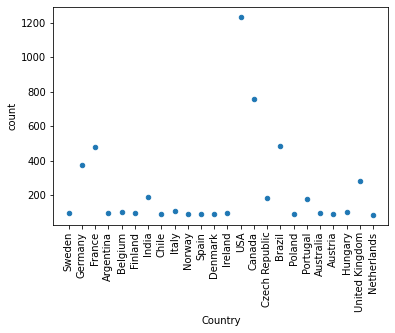

In [59]:
pCountryCountDf.plot.scatter(x='Country', y='count')
plt.xticks(rotation=90);